# 8 | Anomaly Detection and Collaborative Filtering
## 8.1 Anomaly Detection

In [1]:
# import key libraries (remember to pip install numpy etc. first)
import numpy as np
import sys
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import csv data
PATH="./data/"
DATA="ex8data1.mat"

import scipy.io
mat = scipy.io.loadmat(f'{PATH}{DATA}') # training data stored in arrays X, y
X = mat['X']
Xval = mat['Xval']
yval = mat['yval']

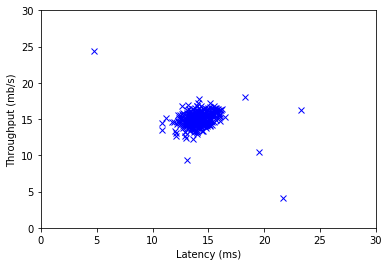

In [3]:
# Visualize the example dataset
plt.plot(X[:, 0], X[:, 1], 'bx')
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)');

## Part 2: Estimate the dataset statistics

In [4]:
def estimateGaussian(X):
    #ESTIMATEGAUSSIAN This function estimates the parameters of a
    #Gaussian distribution using the data in X
    #   [mu sigma2] = estimateGaussian(X),
    #   The input X is the dataset with each n-dimensional data point in one row
    #   The output is an n-dimensional vector mu, the mean of the data set
    #   and the variances sigma^2, an n x 1 vector
    # Useful variables
    m, n = X.shape
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2

In [5]:
def multivariateGaussian(X, mu, Sigma2):
#MULTIVARIATEGAUSSIAN Computes the probability density function of the
#multivariate gaussian distribution.
#    p = MULTIVARIATEGAUSSIAN(X, mu, Sigma2) Computes the probability 
#    density function of the examples X under the multivariate gaussian 
#    distribution with parameters mu and Sigma2. If Sigma2 is a matrix, it is
#    treated as the covariance matrix. If Sigma2 is a vector, it is treated
#    as the \sigma^2 values of the variances in each dimension (a diagonal
#    covariance matrix)
    import math
    k = len(mu)

    if (Sigma2.ndim == 1):
        Sigma2 = np.diag(Sigma2)
    
    XminMu = X - mu#bsxfun(@minus, X, mu(:)');
    p = (2 * math.pi) ** (- k / 2) * np.linalg.det(Sigma2) ** (-0.5) * np.exp(-0.5 * np.sum(XminMu @ np.linalg.pinv(Sigma2) * XminMu,axis=1) )    
    return p

In [6]:
def visualizeFit(X, mu, sigma2):
    #VISUALIZEFIT Visualize the dataset and its estimated distribution.
    #   VISUALIZEFIT(X, p, mu, sigma2) This visualization shows you the 
    #   probability density function of the Gaussian distribution. Each example
    #   has a location (x1, x2) that depends on its feature values.
    
    numberline = np.arange(start=0,step=.5,stop=35)
    X1,X2 = np.meshgrid(numberline, numberline) 
    Z = multivariateGaussian(np.c_[X1.ravel(), X2.ravel()],mu,sigma2)
    Z = Z.reshape(X1.shape)
    
    plt.plot(X[:, 0], X[:, 1],'bx')
    # Do not plot if there are infinities
    print("running plot",np.sum(np.isinf(Z)), Z.shape)
    if (np.sum(np.isinf(Z)) == 0):
        plt.contour(X1, X2, Z, 1/10**np.arange(start=2, step=3, stop=20)[::-1])

In [7]:
print('Visualizing Gaussian fit')

#  Estimate my and sigma2
mu, sigma2 = estimateGaussian(X)

#  Returns the density of the multivariate normal at each data point (row)
#  of X
p = multivariateGaussian(X, mu, sigma2)

Visualizing Gaussian fit


running plot 0 (70, 70)


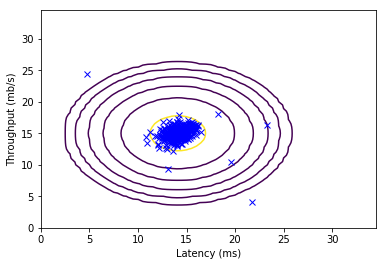

In [8]:
def vis():
    #  Visualize the fit
    visualizeFit(X,  mu, sigma2)
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')
    
vis()

## Part 3: Find Outliers

In [9]:
def selectThreshold(yval, pval):
#SELECTTHRESHOLD Find the best threshold (epsilon) to use for selecting
#outliers
#   [bestEpsilon bestF1] = SELECTTHRESHOLD(yval, pval) finds the best
#   threshold to use for selecting outliers based on the results from a
#   validation set (pval) and the ground truth (yval).
    
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    
    stepsize = (np.max(pval) - np.min(pval)) / 1000
    for epsilon in np.arange(np.min(pval), np.max(pval), stepsize):
        
        prediction = pval < epsilon
        yvalTrue = yval.ravel()==1
        tp = np.sum(yvalTrue * prediction) # true positives count
        tn = np.sum(~yvalTrue * ~prediction) # true negatives count
        fp = np.sum(~yvalTrue * prediction) # false positives count
        fn = np.sum(yvalTrue * ~prediction)
        
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        
        F1 = 2 *(precision * recall)/(precision + recall)
        
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1 

Best epsilon found using cross-validation: 8.990852779269495e-05
   (you should see a value epsilon of about 8.99e-05)

Best F1 on Cross Validation Set:  0.875000
   (you should see a Best F1 value of  0.875000)


running plot 0 (70, 70)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


Text(0.5,0.98,'Outliers shown in RED')

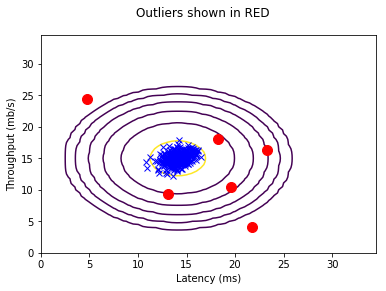

In [10]:
pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print(f'Best epsilon found using cross-validation: {epsilon}')
print('   (you should see a value epsilon of about 8.99e-05)\n')
print(f'Best F1 on Cross Validation Set:  {F1:.6f}')
print('   (you should see a Best F1 value of  0.875000)\n\n')

#  Find the outliers in the training set and plot the
outliers = np.argwhere(p < epsilon).ravel()

#  Draw a red circle around those outliers
f = plt.figure()
vis()
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', linewidth=2, markersize= 10)
f.suptitle('Outliers shown in RED')

## Part 4: Multidimensional Outliers

In [11]:
# import csv data
PATH="./data/"
DATA="ex8data2.mat"

import scipy.io
mat = scipy.io.loadmat(f'{PATH}{DATA}') # training data stored in arrays X, y
X = mat['X']
Xval = mat['Xval']
yval = mat['yval']

In [12]:
#  Apply the same steps to the larger dataset
mu, sigma2 = estimateGaussian(X)

#  Training set
p = multivariateGaussian(X, mu, sigma2)

#  Cross-validation set
pval = multivariateGaussian(Xval, mu, sigma2)

#  Find the best threshold
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: \n', epsilon)
print('   (you should see a value epsilon of about 1.38e-18)')
print('Best F1 on Cross Validation Set:  \n', F1)
print('   (you should see a Best F1 value of 0.615385)')
print(f'# Outliers found: {np.sum(p < epsilon)}')

Best epsilon found using cross-validation: 
 1.377228890761358e-18
   (you should see a value epsilon of about 1.38e-18)
Best F1 on Cross Validation Set:  
 0.6153846153846154
   (you should see a Best F1 value of 0.615385)
# Outliers found: 117


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
